In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import numpy as np

train_df = pd.read_pickle("../data/train_cens.pkl.gz")
train_df.head()

,name,parent,cens_slice,index
0,XC109605,acafly,"[[0.3086012466109237, 0.30568218743577036, 0.3...","(25, 75)"
0,XC109605,acafly,"[[0.37812375487169103, 0.3725999263434882, 0.3...","(157, 207)"
0,XC109605,acafly,"[[0.38193222855739883, 0.3810666924182529, 0.3...","(260, 310)"
0,XC109605,acafly,"[[0.3523993330368658, 0.3480284909351147, 0.34...","(324, 374)"
0,XC109605,acafly,"[[0.3179275282653602, 0.3194400852268083, 0.32...","(361, 411)"


In [2]:
import tensorflow as tf

def reshape_square(arr, k=25):
    """Domain specific. Transform 12x50 matrix into a square matrix that's 25x25."""
    x = np.zeros(k*k)
    a = arr.reshape(-1)
    x[:a.shape[0]] = a
    return x.reshape(k, k, 1)
    
X = np.stack(train_df.cens_slice.apply(reshape_square))

lb = LabelBinarizer()
lb.fit(train_df.parent)
y = lb.transform(train_df.parent)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Softmax, Flatten, Dense
from tensorflow_addons.metrics import F1Score

tf.config.list_physical_devices('GPU')
def get_compiled_model(input_shape=(25, 25, 1), output_shape=397):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(output_shape, activation='sigmoid'))
    
    model.compile(optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy', F1Score(num_classes=output_shape)])
    return model

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [5]:
# https://github.com/tensorpack/tensorpack/blob/5845ead80e3d77c89e2f1e9d5e0691324a8354cc/examples/ResNet/cifar10-preact18-mixup.py#L101-L118

def _mixup(x_in, y_in):
    n = x_in.shape[0]
    # draw from uniform instead of beta(alpha, alpha, BATCH_SIZE)
    w = np.random.uniform(0.3, 0.7, size=n)
    x_weight = w.reshape(n, 1, 1, 1)
    index = np.random.permutation(n)

    x = x_in * x_weight + x_in[index] * (1-x_weight)
    y = y_in + y_in[index]
    
    return x, y

@tf.function(input_signature=[
    tf.TensorSpec(None, tf.float64), 
    tf.TensorSpec(None, tf.int32), 
])
def mixup(x_in, y_in):
    x, y = tf.numpy_function(_mixup, [x_in, y_in], [tf.float64, tf.int32])
    return tf.data.Dataset.from_tensor_slices((
        tf.reshape(x, [-1, 25,25,1]), 
        tf.reshape(y, [-1, 397])
    ))

def add_mixup(dataset, batch_size=1024):
    return (
        dataset
        .shuffle(batch_size)
        .window(batch_size)
        .flat_map(lambda x, y: tf.data.Dataset.zip((x.batch(batch_size), y.batch(batch_size))))
        .map(mixup, num_parallel_calls=tf.data.AUTOTUNE)
        .flat_map(lambda x: x)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

add_mixup(test_dataset)

<PrefetchDataset shapes: ((None, 25, 25, 1), (None, 397)), types: (tf.float64, tf.int32)>

In [6]:
model = get_compiled_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 128)         7

In [7]:
history = model.fit(add_mixup(train_dataset, 256), epochs=5, validation_data=test_dataset.batch(256))

Epoch 1/5
1725/1725 [==============================] - 45s 18ms/step - loss: 0.0487 - accuracy: 0.0176 - f1_score: 0.0011 - val_loss: 0.0173 - val_accuracy: 0.0239 - val_f1_score: 0.0023
Epoch 2/5
1725/1725 [==============================] - 29s 17ms/step - loss: 0.0302 - accuracy: 0.0259 - f1_score: 0.0029 - val_loss: 0.0170 - val_accuracy: 0.0310 - val_f1_score: 0.0047
Epoch 3/5
1725/1725 [==============================] - 29s 17ms/step - loss: 0.0299 - accuracy: 0.0299 - f1_score: 0.0050 - val_loss: 0.0167 - val_accuracy: 0.0360 - val_f1_score: 0.0077
Epoch 4/5
1725/1725 [==============================] - 29s 17ms/step - loss: 0.0297 - accuracy: 0.0330 - f1_score: 0.0075 - val_loss: 0.0167 - val_accuracy: 0.0395 - val_f1_score: 0.0099
Epoch 5/5
1725/1725 [==============================] - 30s 17ms/step - loss: 0.0296 - accuracy: 0.0354 - f1_score: 0.0096 - val_loss: 0.0167 - val_accuracy: 0.0451 - val_f1_score: 0.0125


In [8]:
history = model.fit(add_mixup(train_dataset, 128), epochs=5, validation_data=test_dataset.batch(256))

Epoch 1/5
3450/3450 [==============================] - 46s 13ms/step - loss: 0.0296 - accuracy: 0.0359 - f1_score: 0.0108 - val_loss: 0.0166 - val_accuracy: 0.0458 - val_f1_score: 0.0132
Epoch 2/5
3450/3450 [==============================] - 51s 15ms/step - loss: 0.0294 - accuracy: 0.0373 - f1_score: 0.0127 - val_loss: 0.0166 - val_accuracy: 0.0470 - val_f1_score: 0.0148
Epoch 3/5
3450/3450 [==============================] - 61s 18ms/step - loss: 0.0294 - accuracy: 0.0394 - f1_score: 0.0147 - val_loss: 0.0166 - val_accuracy: 0.0509 - val_f1_score: 0.0177
Epoch 4/5
3450/3450 [==============================] - 70s 20ms/step - loss: 0.0293 - accuracy: 0.0409 - f1_score: 0.0163 - val_loss: 0.0167 - val_accuracy: 0.0520 - val_f1_score: 0.0200
Epoch 5/5
3450/3450 [==============================] - 79s 23ms/step - loss: 0.0292 - accuracy: 0.0415 - f1_score: 0.0178 - val_loss: 0.0166 - val_accuracy: 0.0525 - val_f1_score: 0.0205


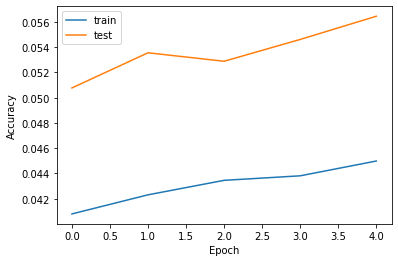

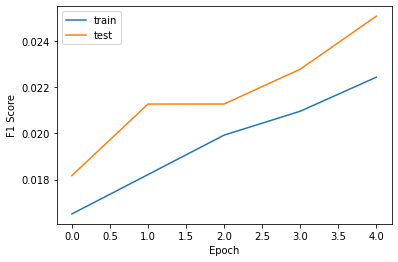

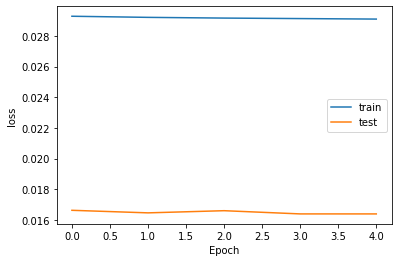

5914/5914 - 75s - loss: 0.0164 - accuracy: 0.0565 - f1_score: 0.0251


[0.01639239303767681,
 0.05645710974931717,
 array([0.        , 0.        , 0.05368647, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.08623298,
        0.        , 0.        , 0.01683244, 0.        , 0.02266783,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.03193613, 0.        , 0.05048077, 0.13626747, 0.        ,
        0.        , 0.        , 0.08225109, 0.        , 0.01988636,
        0.        , 0.        , 0.01051402, 0.00854701, 0.        ,
        0.00574713, 0.00471143, 0.00244798, 0.11893583, 0.        ,
        0.03970742, 0.03938115, 0.00806452, 0.        , 0.        ,
        0.04851753, 0.04903677, 0.03832753, 0.00775194, 0.10070845,
        0.00337268, 0.        , 0.        , 0.        , 0.00671141,
        0.03603604, 0.        , 0.04225352, 0.03724928, 0.01005025,
        0.01923077, 0.17777778, 0.01075269, 0.        , 0.        ,
        0.        , 0.03340292, 0.        , 0.        , 0.        ,
    

In [44]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot([x.mean() for x in history.history['f1_score']], label='train')
plt.plot([x.mean() for x in history.history['val_f1_score']], label='test')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

model.evaluate(X_test, y_test, verbose=2)